# Implementation of Variational Autoencoder in MXNet/Gluon

This is the implementation using the classic MXNet API, i.e. mxnet.sym, mxnet.mod etc.

Ref paper: Kingma, Diederik P., and Max Welling. ["Auto-encoding variational bayes."](https://arxiv.org/abs/1312.6114) arXiv preprint arXiv:1312.6114 (2013).

In [1]:
import time
import numpy as np
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
%matplotlib inline
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)
mx.random.seed(1)
output_fig = False

# Load MNIST

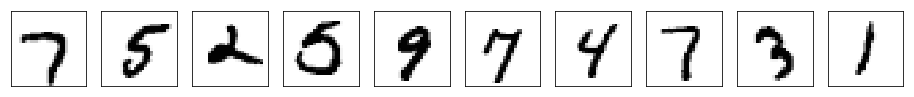

In [2]:
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)
#plt.imshow(mnist['train_data'][0][0],cmap='Greys')

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [3]:
train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

In [4]:
mnist['test_label'].shape

(10000,)

In [5]:
batch_size = 100
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': train_data}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': test_data}, batch_size = batch_size)
#train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
#test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)

# Define model

In [6]:
n_input = 784
n_latent = 2
n_hidden_enc = 400
n_hidden_dec = n_hidden_enc
n_additional_layers = 1  
act_type = 'relu'
soft_zero = 1e-8
model_prefix = 'vae_mxnet_{}d{}l{}h'.format(n_latent, n_additional_layers+1, n_hidden_enc)
output_layer_name = 'output'
# set to 0 to follow the architecture in the original paper

def create_model(make_generator=False):

    if not make_generator:
        data = mx.sym.Variable('data')
        label = mx.sym.Variable('label')
        #data_flat = mx.sym.flatten(data)

        # encoder
        e1 = mx.sym.FullyConnected(data, num_hidden=n_hidden_enc)
        e1act = mx.sym.Activation(e1, act_type=act_type)
        for i in range(n_additional_layers):
            e1 = mx.sym.FullyConnected(e1act, num_hidden=n_hidden_enc)
            e1act = mx.sym.Activation(e1, act_type=act_type)
        mu = mx.sym.FullyConnected(e1act, num_hidden=n_latent, name='enc_mu')
        lv = mx.sym.FullyConnected(e1act, num_hidden=n_latent, name='enc_lv')
        eps = mx.sym.random_normal(loc=0, scale=1, shape=(batch_size, n_latent))
        z = mu + mx.sym.exp(0.5*lv)*eps
        #mx.viz.plot_network(z)

    if make_generator:  # build standalone decoder
        Z = mx.sym.Variable('zsample')
        g1 = mx.sym.FullyConnected(Z, num_hidden=n_hidden_dec, name='gfc0')
    else:
        g1 = mx.sym.FullyConnected(z, num_hidden=n_hidden_dec, name='gfc0')

    g1act = mx.sym.Activation(g1, act_type=act_type, name='gfc0a')
    for i in range(n_additional_layers):
        g1 = mx.sym.FullyConnected(g1act, num_hidden=n_hidden_enc, name='gfc_add{}'.format(i))
        g1act = mx.sym.Activation(g1, act_type=act_type, name='gfc_add{}a'.format(i))
    y = mx.sym.FullyConnected(g1act, num_hidden=n_input, name='y')
    yact = mx.sym.Activation(y, act_type="sigmoid", name=output_layer_name)
    #mx.viz.plot_network(y)
    
    if not make_generator:
        KL = 0.5*mx.sym.sum(1+lv-mx.sym.pow(mu,2)-mx.sym.exp(lv),axis=1, name='KL')
        logloss = mx.sym.sum(
            label * mx.sym.log(yact+soft_zero)+ (1-label) * mx.symbol.log(1-yact+soft_zero), 
            axis=1, name='logloss')
        loss = -logloss-KL
        output = mx.symbol.MakeLoss(sum(loss),name='loss')
    
    if make_generator:
        return yact
    else:
        return output

In [7]:
output = create_model()

In [8]:
#mx.viz.plot_network(yact)

In [9]:
# mx.viz.plot_network(loss)

In [10]:
mod = mx.mod.Module(symbol=output,
                    context=model_ctx,
                    data_names=['data'],
                    label_names=['label'])

# Model training

In [11]:
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier())
mod.init_optimizer(optimizer='adam', optimizer_params=(('learning_rate', 0.001), ))
metric = mx.metric.create('loss')

In [12]:
n_epoch = 50
#early_stopping = 5
#todo implement early stopping
start = time.time()

print_period = n_epoch // 10
training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    train_iter.reset()
    metric.reset()
    #for batch in tqdm_notebook(train_iter, total=n_batches, desc='epoch{}'.format(epoch)):
    for batch in train_iter:
        mod.forward(batch, is_train=True)
        mod.update_metric(metric, labels=batch.label)
        mod.backward()
        mod.update()
    epoch_loss = metric.get()[1]
    training_loss.append(epoch_loss)
    
    # metric.reset()  # metric should be reset within mod.score()
    res = mod.score(test_iter, metric)
    epoch_val_loss = res[0][1]
    validation_loss.append(epoch_val_loss)
    

    #if early_stopping >0:
    #    pass
        
    
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch %d, Training loss %s, Validation loss %s' % (epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

HBox(children=(IntProgress(value=0, description='epochs: ', max=50), HTML(value='')))

Epoch 0, Training loss 185.399083268, Validation loss 170.995874414
Epoch 5, Training loss 150.357458675, Validation loss 153.262231055
Epoch 10, Training loss 144.886427083, Validation loss 146.617145996
Epoch 15, Training loss 142.418114404, Validation loss 144.429382812
Epoch 20, Training loss 140.808182943, Validation loss 144.137408398
Epoch 25, Training loss 139.921277327, Validation loss 143.844525
Epoch 30, Training loss 138.800418164, Validation loss 143.025088281
Epoch 35, Training loss 138.419275228, Validation loss 142.28131377
Epoch 40, Training loss 137.668989469, Validation loss 141.625656348
Epoch 45, Training loss 137.416571029, Validation loss 142.229558496

Time elapsed: 112.40s


In [13]:
mod.save_checkpoint(model_prefix, epoch)
model_save_epoch = epoch

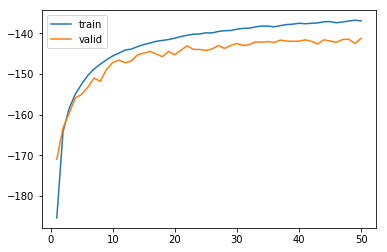

In [14]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

# Load model

In [15]:
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, model_save_epoch)

# Visualizing reconstruction quality

In [16]:
reconstruct=sym.get_internals()[output_layer_name + '_output']

In [17]:
reconstruct_model = mx.mod.Module(symbol=reconstruct, context=model_ctx, data_names=['data'], label_names=None)
reconstruct_model.bind(train_iter.provide_data)
reconstruct_model.set_params(arg_params, aux_params)

In [18]:
test_iter.reset()
test_batch = test_iter.next()
reconstruct_model.forward(test_batch, is_train=False)

In [19]:
result = reconstruct_model.get_outputs()[0].asnumpy()
original = test_batch.data[0].asnumpy()

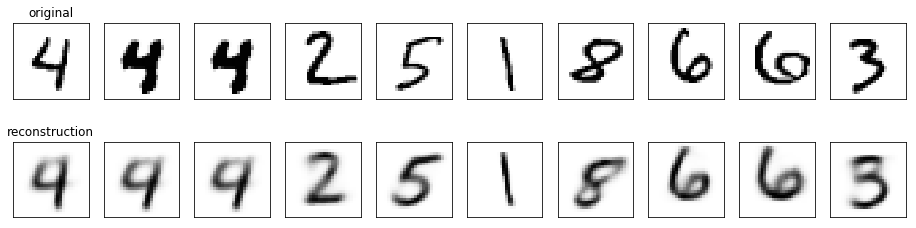

In [20]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

# Visualizing latent space (when it is 2D)

In [21]:
z_mu = sym.get_internals()['enc_mu' + '_output']

In [22]:
latent_model = mx.mod.Module(symbol=z_mu, context=model_ctx, data_names=['data'], label_names=None)

labeled_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, 
                                 batch_size = 1000)
latent_model.bind(labeled_iter.provide_data)
latent_model.set_params(arg_params, aux_params)

In [23]:
batch_data = labeled_iter.next()
latent_model.forward(batch_data, is_train=False)
result = latent_model.get_outputs()[0].asnumpy()

NameError: name 'labels' is not defined

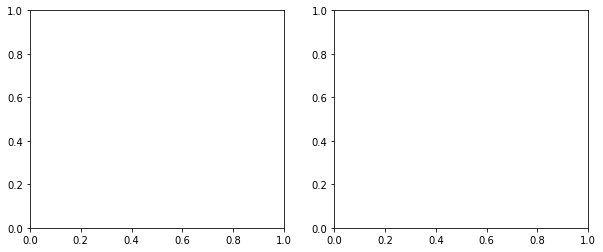

In [24]:
if result.shape[1]==2:
    from scipy.special import ndtri
    from scipy.stats import norm

    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title('scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title('scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_for_test_samples.png')

# Sample latent space and generate images

In [ ]:
generator = create_model(make_generator=True)

## Random sampling

In [ ]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, n_latent))

In [ ]:
arg_dict = arg_params
arg_dict['zsample'] = zsamples
e=generator.bind(ctx=data_ctx, args=arg_dict)
result = e.forward()
images = result[0].asnumpy()

In [ ]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))        
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
if output_fig:
    plt.savefig('generated_samples_with_{}D_latent_space.png'.format(n_latent))

## Grid scan 2D latent space

In [ ]:
if n_latent==2: 
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(x,n_latent,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(idx,n_latent,1)]))

    zsamples = nd.array(x_grid.reshape((n_latent, -1)).transpose())
    zsamples_id = id_grid.reshape((n_latent, -1)).transpose()


    # bind and execute
    arg_dict = arg_params
    arg_dict['zsample'] = zsamples
    e=generator.bind(ctx=data_ctx, args=arg_dict)
    result = e.forward()
    images = result[0].asnumpy()

    #plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))        
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    if output_fig:
        plt.savefig('2d_latent_space_scan_for_generation.png')